In [1]:
from IPython.display import Image
import openmc
import openmc.lib
import numpy as np
import openmc.mgxs as mgxs
import pandas as pdF
import os 
from vtkmodules.all import *
import h5py
import pandas as pd
from matplotlib import pyplot as plt
from numpy import linalg as LA


In [2]:
#Material Properties
plutonium = openmc.Material(name="Pu239")
plutonium.add_nuclide('Pu239',1.0,'ao')
plutonium.set_density('g/cm3',15.7)


beryllium = openmc.Material(name="Be")
beryllium.add_element('Be',1.0)
beryllium.set_density('g/cm3',1.85)
materials = openmc.Materials([plutonium,beryllium])
materials.export_to_xml()

!cat materials.xml

<?xml version='1.0' encoding='utf-8'?>
<materials>
  <material depletable="true" id="1" name="Pu239">
    <density units="g/cm3" value="15.7" />
    <nuclide ao="1.0" name="Pu239" />
  </material>
  <material id="2" name="Be">
    <density units="g/cm3" value="1.85" />
    <nuclide ao="1.0" name="Be9" />
  </material>
</materials>


In [3]:
mesh_library = 'moab' # change to 'libmesh' to use libMesh instead
mesh_file = "PuBeSubtraction.h5m"

# Create DAGMC universes out of h5m files
NeutronBall= openmc.DAGMCUniverse(filename=mesh_file,auto_geom_ids=True)
geometry = openmc.Geometry(root=NeutronBall)
geometry.root_universe = NeutronBall
geometry.export_to_xml()

!cat geometry.xml

<?xml version='1.0' encoding='utf-8'?>
<geometry>
  <dagmc_universe auto_geom_ids="true" filename="PuBeSubtraction.h5m" id="1" />
</geometry>


In [4]:
watt_a = 0.885247
watt_b = 3.80269

batches = 20
num_inactive = 2
num_particles = 60000
energy_distribution = openmc.stats.Watt(watt_a,watt_b)
print(energy_distribution)
settings = openmc.Settings()

settings.batches = batches
settings.inactive = num_inactive
settings.particles = num_particles
settings.temperature = {"multipole": True, "method": "interpolation"}
point = openmc.stats.Point((0, 0, 0))
src = openmc.Source(space=point,energy=energy_distribution)
settings.source = src
settings.export_to_xml()

!cat settings.xml

<?xml version='1.0' encoding='utf-8'?>
<settings>
  <run_mode>eigenvalue</run_mode>
  <particles>60000</particles>
  <batches>20</batches>
  <inactive>2</inactive>
  <source strength="1.0">
    <space type="point">
      <parameters>0 0 0</parameters>
    </space>
    <energy parameters="0.885247 3.80269" type="watt" />
  </source>
  <temperature_method>interpolation</temperature_method>
  <temperature_multipole>true</temperature_multipole>
</settings>


In [5]:
 !mpiexec -np 2 ../../../cardinal-opt -i PuAndBe.i --mesh-only mesh_file.e --n-threads=2 

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [6]:
 !mpiexec -np 2 ../../../cardinal-opt -i PuAndBe.i --n-threads=2

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

       10/1    0.76940    0.77442 +/- 0.00596
       11/1    0.76691    0.77359 +/- 0.00532
       12/1    0.76183    0.77241 +/- 0.00490
       13/1    0.76306    0.77156 +/- 0.00451
       14/1    0.76450    0.77097 +/- 0.00416
       15/1    0.76983    0.77088 +/- 0.00383
       16/1    0.76432    0.77041 +/- 0.00358
       17/1    0.76553    0.77009 +/- 0.00335
       18/1    0.76766    0.76994 +/- 0.00313
       19/1    0.77020    0.76995 +/- 0.00294
       20/1    0.76354    0.76960 +/- 0.00280
 Creating state point statepoint.20.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 1.7441e+00 seconds
   Reading cross sections          = 1.6304e-01 seconds
 Total time in simulation          = 2.0398e+02 seconds
   Time in transport only          = 1.9994e+02 seconds
   Time in inactive batches        = 2.1121e+00 seconds
   Time in active batches          = 2.0187e+02 seconds
   Time synchronizing fission bank = 

In [7]:
r_a = 3.44   #cm
r_b = 10   #cm


#Set sphere geometry and create sphere cell
sphere_geometry = openmc.Sphere(r=r_a)
inside_sphere = -sphere_geometry
outside_sphere = +sphere_geometry

shell_geometry = openmc.Sphere(r=r_b,boundary_type='vacuum')

reflector_region = -shell_geometry & outside_sphere

sphere_cell = openmc.Cell(region = inside_sphere,
                  fill = plutonium)

reflector_cell = openmc.Cell(region=reflector_region,fill=beryllium)


universe = openmc.Universe(cells=[sphere_cell,reflector_cell])


geometry = openmc.Geometry()
geometry.root_universe = universe
geometry.export_to_xml()
geom = geometry

!cat geometry.xml

<?xml version='1.0' encoding='utf-8'?>
<geometry>
  <cell id="1" material="1" region="-1" universe="2" />
  <cell id="2" material="2" region="-2 1" universe="2" />
  <surface coeffs="0.0 0.0 0.0 3.44" id="1" type="sphere" />
  <surface boundary="vacuum" coeffs="0.0 0.0 0.0 10" id="2" type="sphere" />
</geometry>


In [8]:
!mpiexec -np 2 ../../../cardinal-opt -i fluxV3.i --mesh-only mesh_file.e --n-threads=2  

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [9]:
!mpiexec -np 2 ../../../cardinal-opt -i fluxV3.i --n-threads=2

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################


Postprocessor Values:
+----------------+----------------+
| time           | k              |
+----------------+----------------+
|   0.000000e+00 |   0.000000e+00 |
|   1.000000e+00 |   7.679219e-01 |
+----------------+----------------+

Finished Executing                                                                       [181.08 s] [   28 MB]


Multiplicity factor for Dagmc Geometry =  
 0.76743596544029
Multiplicity factor for OpenMc Geometry=  
 0.76792188897929


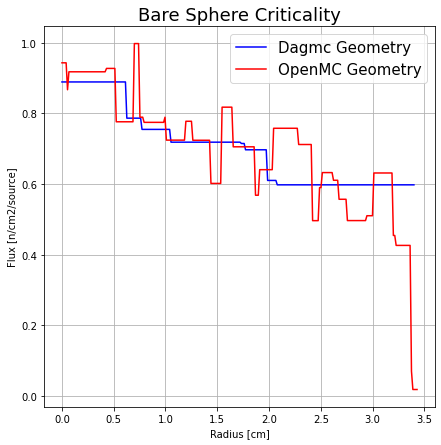

In [10]:

df = pd.read_csv('PuAndBe_out_flux_vec_0001.csv')
df_t = pd.read_csv('PuAndBe_out.csv')

df2 = pd.read_csv('fluxV3_out_flux_vec_0001.csv')
df_t2 = pd.read_csv('fluxV3_out.csv')

plt.figure(figsize=(7,7))
plt.plot(df["z"],df["flux"],"b-",label="Dagmc Geometry")
plt.plot(df2["z"],df2["flux"],"r-",label="OpenMC Geometry")
plt.grid()

plt.xlabel("Radius [cm]")
plt.ylabel("Flux [n/cm2/source]")
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)

print('Multiplicity factor for Dagmc Geometry =  \n',df_t["k"][1])
print('Multiplicity factor for OpenMc Geometry=  \n',df_t2["k"][1])

plt.title("Bare Sphere Criticality")
plt.legend()
plt.show()

In [12]:
with openmc.StatePoint("statepoint.20.h5") as sp:
    tally = sp.tallies[1]
    
    umesh = sp.meshes[1]
    centroids = umesh.centroids
    mesh_vols = umesh.volumes
    #print(mesh_vols)
    #print(centroids)
    
    thermal_flux = tally.get_values(scores=['flux'], 
                                    filters=[openmc.EnergyFilter],
                                    filter_bins=[((0.0, 1),)])
    fast_flux = tally.get_values(scores=['flux'],
                                 filters=[openmc.EnergyFilter],
                                 filter_bins=[((1, 10000000.0),)])
    

OSError: statepoint file has a version of 17.0 which is not consistent with the version expected by OpenMC, 18